In [ ]:
//#Dina Pinchuck 
#Assigment 5 part 1

code for second part: https://colab.research.google.com/drive/1-b8DiITyMJgzMfeDaAu5n9x-6rV87_Md?usp=sharing

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-05-14 08:46:55--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.71.128, 64.233.184.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.71.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  91.6MB/s    in 0.7s    

2021-05-14 08:46:56 (91.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.891.jpg', 'cat.155.jpg', 'cat.943.jpg', 'cat.308.jpg', 'cat.34.jpg', 'cat.942.jpg', 'cat.188.jpg', 'cat.32.jpg', 'cat.735.jpg', 'cat.383.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

In [ ]:
#function that sets up a model, the parameter states if we want dropout or not
def set_up_model(dropout):

  # Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
  # the three color channels: R, G, and B
  img_input = layers.Input(shape=(150, 150, 3))

  # First convolution extracts 16 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  x = layers.Conv2D(16, 3, activation='relu')(img_input)
  x = layers.MaxPooling2D(2)(x)

  # Second convolution extracts 32 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  x = layers.Conv2D(32, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)

  # Third convolution extracts 64 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  x = layers.Conv2D(64, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)
  # Flatten feature map to a 1-dim tensor so we can add fully connected layers
  x = layers.Flatten()(x)

  #adding dropout, based on the parameter that the function recieved
  if dropout:
    x=layers.Dropout(0.5)(x)
  # Create a fully connected layer with ReLU activation and 512 hidden units
  x = layers.Dense(512, activation='relu')(x)

  # Create output layer with a single node and sigmoid activation
  output = layers.Dense(1, activation='sigmoid')(x)

  # Create model:
  # input = input feature map
  # output = input feature map + stacked convolution/maxpooling layers + fully 
  # connected layer + sigmoid output layer
  model = Model(img_input, output)
  model.summary()
  model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])
  return model  

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Data Preprocessing function, first parameter is if we want augmentation or not, second is a model that we built using the set_up_model function
def data_preprocessing(augmentation,model):

  # Data Augmentation like the second example given in class
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,) if augmentation else ImageDataGenerator(rescale=1./255) #if augmentation isnt true we only need to rescale the data
  val_datagen = ImageDataGenerator(rescale=1./255)

  # Flow training images in batches of 20 using train_datagen generator
  train_generator = train_datagen.flow_from_directory(
          train_dir,  # This is the source directory for training images
          target_size=(150, 150),  # All images will be resized to 150x150
          batch_size=20,
          # Since we use binary_crossentropy loss, we need binary labels
          class_mode='binary')

  # Flow validation images in batches of 20 using val_datagen generator
  validation_generator = val_datagen.flow_from_directory(
          validation_dir,
          target_size=(150, 150),
          batch_size=20,
          class_mode='binary')

  #training the model - Fits the model on data yielded batch-by-batch by a Python generator.
  history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,  # 2000 images = batch_size * steps
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50,  # 1000 images = batch_size * steps
        verbose=2)
  return history,validation_generator

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch

#dictonary for holding the test accuracy of the models so we can check which one has the best result
acc_dictonary={}

#saving the training and testing loss and accuracy, with the same keys as the accuracy dictonary, 
#so after we find the best model we can plot graphs for it
loss_acc_dictonary={}

#no augmentation or dropout model
model_none=set_up_model(False) #settting up the model, the parameter is if we want dropout or not
history_none,validation_generator=data_preprocessing(False,model_none) # data preprocessing, the first parameter is if we want augmentation or not, the second is the model we just set up
acc_none= model_none.evaluate(validation_generator, verbose=0)[1] #test accuracy
acc_dictonary["none"]=acc_none #adding the test accuracy to the dictonary
print("the test accuracy for this model is: ",acc_none)#printing the test accuracy
#saving the loss and accuracy in case this is the best model and we need to plot it afterwards
loss_acc_dictonary["none"]=[history_none.history["acc"],history_none.history["val_acc"],history_none.history["loss"],history_none.history["val_loss"]]



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 - 13s - loss: 0.7340 - acc: 0.5565 - val_loss: 0.7617 - val_acc: 0.5520
Epoch 2/30
100/100 - 10s - loss: 0.6168 - acc: 0.6725 - val_loss: 0.5824 - val_acc: 0.6970
Epoch 3/30
100/100 - 10s - loss: 0.5446 - acc: 0.7315 - val_loss: 0.6285 - val_acc: 0.6370
Epoch 4/30
100/100 - 10s - loss: 0.4661 - acc: 0.7765 - val_loss: 0.5657 - val_acc: 0.7400
Epoch 5/30
100/100 - 10s - loss: 0.3842 - acc: 0.8290 - val_loss: 0.8094 - val_acc: 0.6190
Epoch 6/30
100/100 - 10s - loss: 0.2939 - acc: 0.8735 - val_loss: 0.6552 - val_acc: 0.7270
Epoch 7/30
100/100 - 10s - loss: 0.2080 - acc: 0.9105 - val_loss: 1.1291 - val_acc: 0.6640
Epoch 8/30
100/100 - 10s - loss: 0.1401 - acc: 0.9435 - val_loss: 0.8162 - val_acc: 0.7200
Epoch 9/30
100/100 - 10s - loss: 0.0943 - acc: 0.9635 - val_loss: 1.1145 - val_acc: 0.7200
Epoch 10/30
100/100 - 10s - loss: 0.0708 - acc: 0.9760 - val_loss: 1.1399 - val_acc: 0.7140
Epoch 11/30
100/100 - 10s - loss: 0.0509 - acc: 0.9830 - val_loss: 1.4741 - val_acc: 0.71

In [ ]:
#dropout model
model_dropout=set_up_model(True)#parameter states that we want dropout
history_dropout,validation_generator=data_preprocessing(False,model_dropout)#first parameter is augmentation(which we don't want here), second is the model we just built
acc_dropout= model_dropout.evaluate(validation_generator, verbose=0)[1] #test accuracy
acc_dictonary["dropout"]=acc_dropout#adding the accuracy to the dictonary so we can check which model gave the best results afterwords
print("the test accuracy for this model is: ",acc_dropout)#printing the test accuracy
#adding the other parameters to a different dictonary in case this is the model that we need to plot later
loss_acc_dictonary["dropout"]=[history_dropout.history["acc"],history_dropout.history["val_acc"],history_dropout.history["loss"],history_dropout.history["val_loss"]]


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 - 11s - loss: 0.7465 - acc: 0.5445 - val_loss: 0.7533 - val_acc: 0.5160
Epoch 2/30
100/100 - 10s - loss: 0.6334 - acc: 0.6560 - val_loss: 0.6059 - val_acc: 0.6550
Epoch 3/30
100/100 - 10s - loss: 0.5653 - acc: 0.7115 - val_loss: 0.6316 - val_acc: 0.6300
Epoch 4/30
100/100 - 10s - loss: 0.5164 - acc: 0.7455 - val_loss: 0.6219 - val_acc: 0.6990
Epoch 5/30
100/100 - 10s - loss: 0.4582 - acc: 0.7880 - val_loss: 0.5676 - val_acc: 0.7350
Epoch 6/30
100/100 - 10s - loss: 0.3987 - acc: 0.8175 - val_loss: 0.6122 - val_acc: 0.7270
Epoch 7/30
100/100 - 10s - loss: 0.3487 - acc: 0.8450 - val_loss: 0.5340 - val_acc: 0.7520
Epoch 8/30
100/100 - 10s - loss: 0.2912 - acc: 0.8760 - val_loss: 0.6748 - val_acc: 0.6990
Epoch 9/30
100/100 - 10s - loss: 0.2586 - acc: 0.8940 - val_loss: 0.6821 - val_acc: 0.7440
Epoch 10/30
100/100 - 10s - loss: 0.2191 - acc: 0.9015 - val_loss: 0.7463 - val_acc: 0.7500
Epoch 11/30
100/100 - 10s - loss: 0.1956 - acc: 0.9260 - val_loss: 0.8828 - val_acc: 0.7440
Epoch 12

In [ ]:

#augmentation model
model_augmentation=set_up_model(False)#paramter is if we want dropout or not(in this model, we don't want dropout)
history_augmentation,validation_generator=data_preprocessing(True,model_augmentation)#first parameter is augmentation (which we want in this model), the second is the model we just built
acc_augmentation= model_augmentation.evaluate(validation_generator, verbose=0)[1]#test accuracy
acc_dictonary["augmentation"]=acc_augmentation#adding it to a dictonary so we can check which model has the best results after words
print("the test accuracy for this model is: ",acc_augmentation)#printing the test accuracy
#adding the other parameters to a different dictonary in case we need to plot them
loss_acc_dictonary["augmentation"]=[history_augmentation.history["acc"],history_augmentation.history["val_acc"],history_augmentation.history["loss"],history_augmentation.history["val_loss"]]



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 - 21s - loss: 0.7631 - acc: 0.5435 - val_loss: 0.7244 - val_acc: 0.5020
Epoch 2/30
100/100 - 20s - loss: 0.6707 - acc: 0.5860 - val_loss: 0.6345 - val_acc: 0.6590
Epoch 3/30
100/100 - 20s - loss: 0.6498 - acc: 0.6240 - val_loss: 0.6036 - val_acc: 0.6840
Epoch 4/30
100/100 - 20s - loss: 0.6267 - acc: 0.6500 - val_loss: 0.6326 - val_acc: 0.6640
Epoch 5/30
100/100 - 20s - loss: 0.6337 - acc: 0.6605 - val_loss: 0.6472 - val_acc: 0.6800
Epoch 6/30
100/100 - 20s - loss: 0.6138 - acc: 0.6530 - val_loss: 0.5664 - val_acc: 0.7060
Epoch 7/30
100/100 - 20s - loss: 0.6141 - acc: 0.6690 - val_loss: 0.5652 - val_acc: 0.7100
Epoch 8/30
100/100 - 20s - loss: 0.5996 - acc: 0.6780 - val_loss: 0.5604 - val_acc: 0.6920
Epoch 9/30
100/100 - 20s - loss: 0.5980 - acc: 0.6890 - val_loss: 0.5561 - val_acc: 0.7330
Epoch 10/30
100/100 - 20s - loss: 0.5738 - acc: 0.6975 - val_loss: 0.5712 - val_acc: 0.7030
Epoch 11/30
100/100 - 20s - loss: 0.5765 - acc: 0.7015 - val_loss: 0.5429 - val_acc: 0.72

In [ ]:

#dropout and augmentation model
model_dropout_augmentation=set_up_model(True)#paramters states that we want dropout
history_dropout_augmentation,validation_generator=data_preprocessing(True,model_dropout_augmentation)#first parameter states that we want augmentation is this model, the second is the model that we just set up
acc_dropout_augmentation= model_dropout_augmentation.evaluate(validation_generator, verbose=0)[1]#test accuracy
acc_dictonary["dropout_augmentation"]=acc_dropout_augmentation#adding the accuracy to a dictonary so we can check which model gives the best results
print("the test accuracy for this model is: ",acc_dropout_augmentation)#printing the test accuracy
#adding the other parameters to a different graph in case we need to plot this model
loss_acc_dictonary["dropout_augmentation"]=[history_dropout_augmentation.history["acc"],history_dropout_augmentation.history["val_acc"],history_dropout_augmentation.history["loss"],history_dropout_augmentation.history["val_loss"]]



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 64)        0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 - 21s - loss: 0.7638 - acc: 0.5210 - val_loss: 0.7213 - val_acc: 0.5330
Epoch 2/30
100/100 - 20s - loss: 0.6760 - acc: 0.5740 - val_loss: 0.6262 - val_acc: 0.6310
Epoch 3/30
100/100 - 20s - loss: 0.6422 - acc: 0.6240 - val_loss: 0.7320 - val_acc: 0.5410
Epoch 4/30
100/100 - 20s - loss: 0.6305 - acc: 0.6535 - val_loss: 0.6988 - val_acc: 0.5960
Epoch 5/30
100/100 - 20s - loss: 0.6317 - acc: 0.6525 - val_loss: 0.6044 - val_acc: 0.6790
Epoch 6/30
100/100 - 20s - loss: 0.6243 - acc: 0.6635 - val_loss: 0.6499 - val_acc: 0.6170
Epoch 7/30
100/100 - 20s - loss: 0.6177 - acc: 0.6485 - val_loss: 0.5866 - val_acc: 0.6940
Epoch 8/30
100/100 - 20s - loss: 0.6147 - acc: 0.6575 - val_loss: 0.5995 - val_acc: 0.6740
Epoch 9/30
100/100 - 20s - loss: 0.6082 - acc: 0.6730 - val_loss: 0.6168 - val_acc: 0.6790
Epoch 10/30
100/100 - 20s - loss: 0.6070 - acc: 0.6760 - val_loss: 0.6009 - val_acc: 0.7050
Epoch 11/30
100/100 - 20s - loss: 0.6042 - acc: 0.6655 - val_loss: 0.5555 - val_acc: 0.71

{'none': 0.7120000123977661, 'dropout': 0.7609999775886536, 'augmentation': 0.7789999842643738, 'dropout_augmentation': 0.7229999899864197}
the model:  augmentation  has the max accuracy of  0.7789999842643738


Text(0.5, 1.0, 'Training and validation loss for max accuracy model')

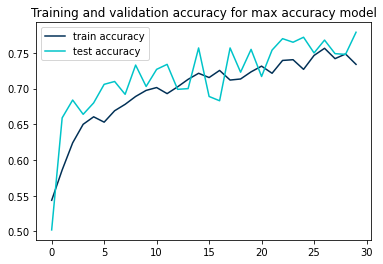

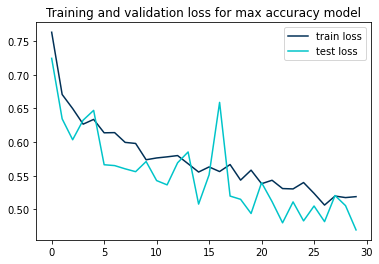

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#printing the dictonary out - another way to verify our results
print(acc_dictonary)

#finding the model which gives the best results
max_acc=max(acc_dictonary, key=acc_dictonary.get)#finds the key which has the max value
print("the model: ", max_acc, " has the max accuracy of ", acc_dictonary[max_acc])

#taking the parameters we need for graphing the results of the best model
acc,val_acc,loss,val_loss= loss_acc_dictonary[max_acc]

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch for the model with the best results
plt.plot(epochs, acc,label="train accuracy",color='#013056')
plt.plot(epochs, val_acc,label="test accuracy",color='#00c4c9' )
plt.legend() #shows the box on the graph that has the line name and color
plt.title('Training and validation accuracy for max accuracy model')

plt.figure()

# Plot training and validation loss per epoch for the model with the best results
plt.plot(epochs, loss,label="train loss",color='#013056')
plt.plot(epochs, val_loss,label="test loss",color='#00c4c9' )
plt.legend() #shows the box on the graph that has the line name and color
plt.title('Training and validation loss for max accuracy model')


code for getting 95% or more accuracy : https://colab.research.google.com/drive/1-b8DiITyMJgzMfeDaAu5n9x-6rV87_Md?usp=sharing